# 5-height

In [316]:
#mapping
sym2pitch = {"<t0>":0,"<t1>":4,"<t2>":3,"<t3>":1,"<t4>":5}

In [375]:
!head 5_height_scansion_from_cantonese_songs.txt

melody	5-height
9 9 10 9 7 5 7 7 0	<t3> <t3> <t2> <t3> <t1> <t2> <t4> <t4> <t0>
8 8 10 8 7 5 7 7 0	<t2> <t2> <t1> <t2> <t4> <t2> <t4> <t1> <t3>
2 10 7 4 0 4 5 5 7	<t3> <t4> <t3> <t3> <t0> <t3> <t2> <t2> <t4>
2 4 0 2	<t4> <t1> <t2> <t2>
4 4 5 4 2 0 2	<t4> <t4> <t4> <t4> <t1> <t2> <t4>
0 2 10 7 5 4 5	<t0> <t3> <t4> <t4> <t2> <t3> <t2>
3 7 0 3 5 5	<t2> <t4> <t0> <t2> <t4> <t4>
3 3 0 3 8 12 5 5 7	<t2> <t2> <t3> <t2> <t2> <t4> <t0> <t0> <t3>
2 10 7 4 0 9 5	<t3> <t4> <t4> <t3> <t0> <t1> <t2>


In [317]:
#preprocess: filter out lines starting with '<t0>'

processed_melody = list()
processed_scansion = list()

with open("./5_height_scansion_from_cantonese_songs.txt","r") as fin:
    lines = [line.strip() for line in fin.readlines()]
    c = 0
    for sent in lines[1:]:
        sent = sent.split("\t")
        melody,scansion = sent[0].split()," ".join(sent[1].split())
        if scansion.split()[0] != "<t0>":
            melody_symbols = list()
            for m in melody:
                melody_symbols.append(int(m))
            processed_melody.append(melody_symbols)
            processed_scansion.append([sym2pitch[x] for x in scansion.split()])
                    
test_melody = processed_melody[round(len(processed_melody)*0.9):]
test_scansion = processed_scansion[round(len(processed_scansion)*0.9):]
train_melody = processed_melody[:round(len(processed_melody)*0.9)]
train_scansion = processed_scansion[:round(len(processed_scansion)*0.9)]

print(len(test_melody),len(test_melody) == len(test_scansion))

833 True


In [318]:
test_scansion

[[5, 5, 3, 5, 5, 3, 3],
 [4, 5, 3, 1, 1],
 [5, 5, 3, 3, 3],
 [1, 3, 3, 3, 1, 1, 3, 4, 5, 0],
 [3, 3, 3, 1, 4, 4, 4, 3, 1, 3],
 [1, 1, 3, 3],
 [1, 1, 3, 1],
 [4, 5, 3, 1, 1],
 [5, 3, 3, 5, 3],
 [3, 1, 0, 5, 1, 1],
 [1, 3, 3, 3, 3, 1, 3, 5, 3, 0],
 [3, 3, 3, 1, 5, 3, 5, 3, 3, 3],
 [1, 1, 3, 4],
 [1, 1, 3, 1],
 [5, 0, 1, 1, 3, 5, 0, 0, 1, 5],
 [3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 1],
 [5, 3, 3, 5, 5, 3, 3, 5, 4, 5],
 [3, 5, 5, 5, 1, 1, 0, 3, 5, 0, 1, 3],
 [4, 4, 5, 4, 3, 1, 3, 5],
 [3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1],
 [1, 4, 4, 5, 4, 3, 3, 4, 5, 5],
 [3, 3, 3, 0, 1, 5, 5],
 [1, 3, 1, 1],
 [4, 0, 3, 1, 3],
 [4, 4, 3, 1, 1],
 [1, 0, 0, 3, 5, 1, 3, 5, 4, 1, 0, 1, 3, 5, 3],
 [1, 5, 3, 1, 3, 4, 3, 3, 3, 3, 1, 3, 5, 3, 3],
 [1, 5, 3, 1, 1, 4, 5, 5, 3, 0, 1, 3, 1, 1, 3],
 [3, 3, 4, 5, 5, 3, 3, 3, 3, 5, 4],
 [3, 4, 3, 3, 3, 3, 5, 1, 1, 3, 1],
 [1, 5, 5, 0, 5, 0, 3, 3, 1, 3],
 [1, 3, 5, 5, 5, 3, 4],
 [3, 5, 5, 5, 1, 0, 0, 5],
 [3, 3, 3, 3, 3, 0, 1, 4],
 [3, 3, 5, 5, 0, 3, 3, 3, 5, 3],
 [3, 3, 1, 3,

In [319]:
# Tone 1,2,3,4,5
# Relative pitch 4,3,1,5,0
# Rule 1. 轻声（5）不能出现在第一个位置，􀁘用力小，􀁙音强弱，􀁚音长短
# Rule 2. 三声不可能连续存在。当前一个位置是三声时，后一个就不可能是三声 
import numpy as np
import itertools
from numpy.linalg import norm

def no_two_adjacent_zeros_tone3(lst):
    for i in range(len(lst) - 1):
        if lst[i] == 0 and lst[i+1] == 0:
            return False
        elif lst[i] == 1 and lst[i+1] == 1:
            return False
    return True

def all_tone_possibility(melody):
    n = len(melody)
    result = []
    # Generate all possible lists
    possible_lists = list(itertools.product([0,1,3,4,5], repeat=n-1))
    for first_element in [1,3,4,5]:
        for lst in possible_lists:
            result.append([first_element] + list(lst))
    result = list(filter(no_two_adjacent_zeros_tone3, result))

    # Filter out the lists that have the first element as 0
    result = list(filter(lambda x: x[0] != 0, result))


    return result

In [320]:
def calculate_deltas(numbers):#shifted
    mini = min(numbers)
    res = list()
    for num in numbers:
        res.append(num-mini)
    
    return res

# Example usage
input_numbers = [80, 78, 76, 76, 78]
delta_list = calculate_deltas(input_numbers)
print(delta_list)


[4, 2, 0, 0, 2]


In [321]:
def best_5_scansion(input_num,threshold):#change number of candidates
    best_tone_top5 = dict()
    deltas = calculate_deltas(input_num)
    
    for cd in all_tone_possibility(deltas):
        cd = np.array(cd)
        norm_pitch = np.array(deltas)
        cos_sim = np.dot(cd, deltas) / (norm(cd) * norm(deltas))
        if len(best_tone_top5) < threshold:
            best_tone_top5[cos_sim] = cd
        else:
            if cos_sim >= min(best_tone_top5.keys()):
                del best_tone_top5[min(best_tone_top5.keys())]
                best_tone_top5[cos_sim] = cd
            else:
                pass
    return best_tone_top5 #relative pitch of tones

In [322]:
list(best_5_scansion([1,2,3],1).values())[0].tolist()

[1, 3, 5]

In [323]:
test_melody

[[9, 4, 2, 4, 2, 0, 0],
 [7, 5, 3, 0, 0],
 [5, 4, 2, 0, 0],
 [2, 5, 5, 5, 4, 2, 7, 9, 9, 0],
 [1, 3, 5, 7, 8, 7, 7, 3, 0, 3],
 [0, 0, 1, 3],
 [0, 0, 1, 0],
 [7, 5, 3, 0, 0],
 [5, 4, 2, 4, 0],
 [3, 2, 0, 7, 2, 2],
 [2, 5, 5, 5, 4, 2, 7, 9, 9, 0],
 [1, 3, 5, 7, 8, 7, 7, 3, 0, 3],
 [0, 0, 1, 3],
 [0, 0, 1, 0],
 [0, 2, 4, 4, 5, 7, 5, 7, 9, 12],
 [3, 3, 3, 3, 2, 0, 0, 2, 3, 3, 2, 0],
 [9, 4, 4, 4, 2, 0, 0, 2, 4, 4],
 [3, 3, 3, 3, 1, 0, 0, 1, 3, 3, 5, 6],
 [3, 3, 3, 3, 1, 0, 1, 3],
 [3, 3, 3, 3, 2, 0, 0, 2, 3, 3, 2, 0],
 [9, 4, 4, 4, 2, 0, 0, 2, 4, 4],
 [0, 0, 0, 0, 2, 3, 2],
 [2, 3, 2, 0],
 [7, 5, 3, 0, 0],
 [7, 5, 3, 0, 0],
 [0, 2, 4, 5, 7, 4, 2, 4, 5, 2, 0, 4, 9, 11, 7],
 [9, 12, 10, 9, 7, 10, 9, 7, 5, 0, 2, 5, 7, 5, 5],
 [9, 12, 10, 9, 7, 10, 9, 7, 5, 0, 2, 5, 5, 4, 5],
 [4, 4, 4, 4, 4, 0, 2, 2, 2, 4, 2],
 [1, 1, 1, 1, 1, 3, 5, 0, 0, 1, 0],
 [2, 9, 9, 9, 7, 0, 5, 5, 2, 5],
 [0, 2, 4, 2, 2, 0, 2],
 [4, 4, 5, 4, 4, 0, 2, 7],
 [3, 3, 3, 3, 3, 0, 2, 7],
 [0, 0, 2, 4, 4, 6, 7, 7, 9, 7],
 [3, 

In [324]:
output_scansion

[array([5, 3, 1, 3, 1, 0, 0]),
 array([5, 4, 3, 0, 1]),
 array([5, 5, 3, 0, 1]),
 array([1, 4, 4, 4, 3, 1, 5, 5, 5, 0]),
 array([1, 3, 4, 5, 5, 5, 5, 3, 0, 3]),
 array([1, 0, 1, 5]),
 array([1, 0, 5, 0]),
 array([5, 4, 3, 0, 1]),
 array([4, 3, 1, 3, 0]),
 array([3, 1, 0, 5, 1, 1]),
 array([1, 4, 4, 4, 3, 1, 5, 5, 5, 0]),
 array([1, 3, 4, 5, 5, 5, 5, 3, 0, 3]),
 array([1, 0, 1, 5]),
 array([1, 0, 5, 0]),
 array([1, 3, 5, 5, 5, 5, 5, 5, 5, 5]),
 array([5, 5, 5, 5, 3, 0, 0, 3, 5, 5, 3, 0]),
 array([5, 3, 3, 3, 1, 0, 0, 1, 3, 3]),
 array([3, 3, 3, 3, 1, 0, 0, 1, 3, 3, 5, 5]),
 array([3, 3, 3, 3, 1, 0, 1, 3]),
 array([5, 5, 5, 5, 3, 0, 0, 3, 5, 5, 3, 0]),
 array([5, 3, 3, 3, 1, 0, 0, 1, 3, 3]),
 array([1, 0, 1, 0, 5, 5, 4]),
 array([3, 5, 3, 0]),
 array([5, 4, 3, 0, 1]),
 array([5, 4, 3, 0, 1]),
 array([1, 3, 3, 4, 5, 3, 1, 3, 4, 1, 0, 3, 5, 5, 5]),
 array([4, 5, 4, 4, 3, 4, 4, 3, 3, 0, 1, 3, 3, 3, 3]),
 array([4, 5, 4, 4, 3, 4, 4, 3, 3, 0, 1, 3, 3, 1, 3]),
 array([3, 3, 3, 3, 3, 0, 1, 1, 1

In [325]:
test_scansion

[[5, 5, 3, 5, 5, 3, 3],
 [4, 5, 3, 1, 1],
 [5, 5, 3, 3, 3],
 [1, 3, 3, 3, 1, 1, 3, 4, 5, 0],
 [3, 3, 3, 1, 4, 4, 4, 3, 1, 3],
 [1, 1, 3, 3],
 [1, 1, 3, 1],
 [4, 5, 3, 1, 1],
 [5, 3, 3, 5, 3],
 [3, 1, 0, 5, 1, 1],
 [1, 3, 3, 3, 3, 1, 3, 5, 3, 0],
 [3, 3, 3, 1, 5, 3, 5, 3, 3, 3],
 [1, 1, 3, 4],
 [1, 1, 3, 1],
 [5, 0, 1, 1, 3, 5, 0, 0, 1, 5],
 [3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 1],
 [5, 3, 3, 5, 5, 3, 3, 5, 4, 5],
 [3, 5, 5, 5, 1, 1, 0, 3, 5, 0, 1, 3],
 [4, 4, 5, 4, 3, 1, 3, 5],
 [3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1],
 [1, 4, 4, 5, 4, 3, 3, 4, 5, 5],
 [3, 3, 3, 0, 1, 5, 5],
 [1, 3, 1, 1],
 [4, 0, 3, 1, 3],
 [4, 4, 3, 1, 1],
 [1, 0, 0, 3, 5, 1, 3, 5, 4, 1, 0, 1, 3, 5, 3],
 [1, 5, 3, 1, 3, 4, 3, 3, 3, 3, 1, 3, 5, 3, 3],
 [1, 5, 3, 1, 1, 4, 5, 5, 3, 0, 1, 3, 1, 1, 3],
 [3, 3, 4, 5, 5, 3, 3, 3, 3, 5, 4],
 [3, 4, 3, 3, 3, 3, 5, 1, 1, 3, 1],
 [1, 5, 5, 0, 5, 0, 3, 3, 1, 3],
 [1, 3, 5, 5, 5, 3, 4],
 [3, 5, 5, 5, 1, 0, 0, 5],
 [3, 3, 3, 3, 3, 0, 1, 4],
 [3, 3, 5, 5, 0, 3, 3, 3, 5, 3],
 [3, 3, 1, 3,

In [326]:
import copy

In [327]:
def forward_similarity(melody,lst):
    nan = [0] * len(melody)
    if melody != nan:
        melody = np.array(melody)
        next_lst = list()
        maxi = 0

        tone_pitch = [0,1,3,4,5]
        for i in tone_pitch:
            tmp = list()
            tmp = copy.deepcopy(lst)
            tmp = np.append(tmp, i)
            cos_sim = np.dot(melody,tmp)/ (norm(melody) * norm(tmp))

            if maxi < cos_sim:
                next_lst = tmp
                maxi = cos_sim
            else:
                pass
        return next_lst
    else:
        return np.array(melody)

forward_similarity([9, 4, 2, 4, 2,0,9],[4, 1, 0, 1, 0,2])

array([4, 1, 0, 1, 0, 2, 5])

In [328]:
def best_1_scansion(input_num):#change number of candidates
    nan = [0] * len(input_num)
    if input_num != nan:
        best_tone_top = list()
        compare = 0
        deltas = calculate_deltas(input_num)
        for cd in all_tone_possibility(deltas[:5]):
            tmp = deltas[:5]
            cd = np.array(cd)
            norm_pitch = np.array(deltas)
            cos_sim = np.dot(cd, tmp) / (norm(cd) * norm(tmp))
    #         print(tmp,cd,cos_sim)
            if compare < cos_sim:
                best_tone_top = cd
                compare = cos_sim
    #             print("best",best_tone_top,cos_sim)
            else:
                pass

        for idx in range(5,len(deltas)):
            num = deltas[:idx +1]
            best_tone_top = forward_similarity(num,best_tone_top)

        return best_tone_top #relative pitch of tones
    else:
        print(input_num)
        return np.array(input_num)

In [329]:
best_1_scansion([9, 4, 2, 4, 2, 0, 0,2,4,6])

array([5, 3, 1, 3, 1, 0, 0, 1, 3, 4])

In [330]:
cos_sim = np.dot([0,0,0,0],[1,1,1,1])/ (norm([0,0,0,0]) * norm([1,1,1,1]))
print(cos_sim)

nan


/Users/yiwen/anaconda3/envs/lightning/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [331]:
best_1_scansion([0,0,0,0])

[0, 0, 0, 0]


array([0, 0, 0, 0])

In [332]:
melody

['0', '3']

In [344]:
with open("./scansion_results/similarity_scansion_5_height.txt","w") as fout:
    fout.write("5-height" + "\t" + "truth" + "\t "+"accuracy" + "\n")
    output_scansion_5 = list()
    for idx in range(len(test_melody)):
    for melody in test_melody:
        res = best_1_scansion(melody)
        output_scansion_5.append(res)
        if len(melody) % 50 == 0:
            print(len(melody))
        fout.write(" ".join([str(x) for x in res.tolist()]) + "\t" +  +"\n")

[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0]


/Users/yiwen/anaconda3/envs/lightning/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/yiwen/anaconda3/envs/lightning/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [343]:
!head ./scansion_results/similarity_scansion_5_height.txt

5 3 1 3 1 0 0
5 4 3 0 1
5 5 3 0 1
1 4 4 4 3 1 5 5 5 0
1 3 4 5 5 5 5 3 0 3
1 0 1 5
1 0 5 0
5 4 3 0 1
4 3 1 3 0
3 1 0 5 1 1


In [308]:
len(output_scansion)

833

In [309]:
output_scansion_5[0].tolist()

[5, 3, 1, 3, 1, 0, 0]

In [310]:
test_scansion[0]

[5, 5, 3, 5, 5, 3, 3]

In [311]:
def count_same_elements(lst1, lst2):
    # Check if the strings have the same length
    if len(lst1) != len(lst2):
        raise ValueError("Lists must have the same length")

    # Initialize a count for different letters
    count = 0

    # Iterate through the strings and compare characters at the same index
    for i in range(len(lst1)):
        if lst1[i] == lst2[i]:
            count += 1

    return count

def mean_accuracy(lst1,lst2):
    return count_same_elements(lst1,lst2)/len(lst1)

In [312]:
mean_performance_5 = list()
for idx in range(len(output_scansion)):
    mean_performance_5.append(mean_accuracy(output_scansion[idx].tolist(),test_scansion[idx]))

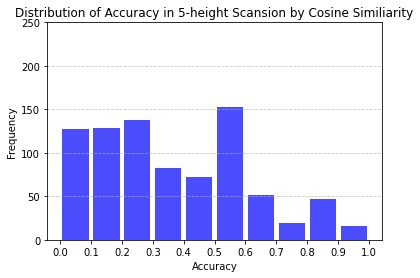

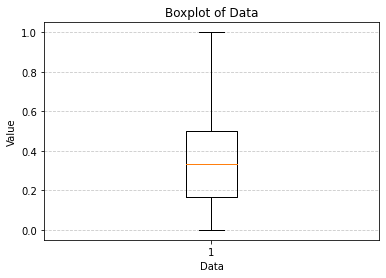

In [313]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace this with your own list of numbers)
data = mean_performance_5

# Define the range and interval for the x-axis
x_min = min(data)
x_max = max(data)
x_interval = 0.1
bins = np.arange(x_min, x_max + x_interval, x_interval)

# Create a histogram
plt.hist(data, bins=bins, color='blue', alpha=0.7, rwidth=0.85)
plt.xticks(np.arange(x_min, x_max + x_interval, x_interval))
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.ylim(0,250)
plt.title("Distribution of Accuracy in 5-height Scansion by Cosine Similiarity")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Create a boxplot
plt.boxplot(data)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Boxplot of Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [314]:
sum(mean_performance_5)/len(mean_performance_5)

0.35440198498157

# 3-height

In [359]:
# mapping
symbol2num = {"<l>":"0","<m>":"3","<h>":"5"}

#preprocess: filter out lines starting with '<t0>'

with open("./5_height_scansion_from_cantonese_songs.txt","r") as fin:
    five_height = [line.strip() for line in fin.readlines()]
    
with open("./3_height_scansion_from_cantonese_songs.txt","r") as fin:
    three_height = [line.strip() for line in fin.readlines()]   


print(len(five_height),len(three_height))

processed_melody = list()
processed_scansion = list()

for idx in range(1,len(five_height[1:])+1):
    sent = five_height[idx]
    sent = sent.split("\t")
    melody,scansion = sent[0].split()," ".join(sent[1].split())
    if scansion.split()[0] != "<t0>":
        scansion_three = " ".join(three_height[idx].split("\t")[1].split())
        melody_symbols = list()
        for m in melody:
            melody_symbols.append(int(m))
        processed_melody.append(melody_symbols)
        processed_scansion.append([s for s in scansion_three.split()])

print(len(processed_scansion) == len(processed_melody))

print(len(processed_melody))

test_melody = processed_melody[round(len(processed_melody)*0.9):]
test_scansion = processed_scansion[round(len(processed_scansion)*0.9):]

11500 11500
True
8335


In [360]:
processed_scansion

[['<m>', '<m>', '<m>', '<m>', '<h>', '<m>', '<h>', '<h>', '<l>'],
 ['<m>', '<m>', '<h>', '<m>', '<h>', '<m>', '<h>', '<h>', '<m>'],
 ['<m>', '<h>', '<m>', '<m>', '<l>', '<m>', '<m>', '<m>', '<h>'],
 ['<h>', '<h>', '<m>', '<m>'],
 ['<h>', '<h>', '<h>', '<h>', '<h>', '<m>', '<h>'],
 ['<m>', '<h>', '<l>', '<m>', '<h>', '<h>'],
 ['<m>', '<m>', '<m>', '<m>', '<m>', '<h>', '<l>', '<l>', '<m>'],
 ['<m>', '<h>', '<h>', '<m>', '<l>', '<h>', '<m>'],
 ['<m>', '<m>', '<m>', '<m>', '<h>', '<m>', '<h>', '<h>', '<l>'],
 ['<m>', '<m>', '<m>', '<m>', '<h>', '<m>', '<m>', '<h>', '<m>'],
 ['<m>',
  '<h>',
  '<h>',
  '<m>',
  '<l>',
  '<m>',
  '<m>',
  '<m>',
  '<h>',
  '<h>',
  '<h>',
  '<m>',
  '<m>'],
 ['<m>', '<h>', '<h>', '<h>', '<m>', '<h>'],
 ['<m>', '<m>', '<h>', '<m>', '<m>'],
 ['<m>', '<h>', '<l>', '<m>', '<h>', '<h>', '<m>'],
 ['<m>', '<m>', '<m>', '<m>', '<h>', '<l>', '<l>', '<m>'],
 ['<m>', '<m>', '<h>', '<h>', '<m>', '<l>', '<h>', '<m>'],
 ['<h>', '<m>', '<h>', '<l>', '<h>', '<h>', '<m>'],
 

In [361]:
def all_tone_possibility(melody):
    n = len(melody)
    result = []
    # Generate all possible lists
    possible_lists = list(itertools.product([0,3,5], repeat=n-1))
    for first_element in [0,3,5]:
        for lst in possible_lists:
            result.append([first_element] + list(lst))
    result = list(filter(no_two_adjacent_zeros_tone3, result))

    # Filter out the lists that have the first element as 0
    result = list(filter(lambda x: x[0] != 0, result))


    return result

In [364]:
def forward_similarity(melody,lst):
    nan = [0] * len(melody)
    if melody != nan:
        melody = np.array(melody)
        next_lst = list()
        maxi = 0

        tone_pitch = [0,3,5]
        for i in tone_pitch:
            tmp = list()
            tmp = copy.deepcopy(lst)
            tmp = np.append(tmp, i)
            cos_sim = np.dot(melody,tmp)/ (norm(melody) * norm(tmp))

            if maxi < cos_sim:
                next_lst = tmp
                maxi = cos_sim
            else:
                pass
        return next_lst
    else:
        return np.array(melody)

forward_similarity([9, 4, 2, 4, 2,0,9],[5, 0, 3, 0, 0,3])

array([5, 0, 3, 0, 0, 3, 5])

In [365]:
def best_1_scansion(input_num):#change number of candidates
    nan = [0] * len(input_num)
    if input_num != nan:
        best_tone_top = list()
        compare = 0
        deltas = calculate_deltas(input_num)
        for cd in all_tone_possibility(deltas[:5]):
            tmp = deltas[:5]
            cd = np.array(cd)
            norm_pitch = np.array(deltas)
            cos_sim = np.dot(cd, tmp) / (norm(cd) * norm(tmp))
    #         print(tmp,cd,cos_sim)
            if compare < cos_sim:
                best_tone_top = cd
                compare = cos_sim
    #             print("best",best_tone_top,cos_sim)
            else:
                pass

        for idx in range(5,len(deltas)):
            num = deltas[:idx +1]
            best_tone_top = forward_similarity(num,best_tone_top)

        return best_tone_top #relative pitch of tones
    else:
        print(input_num)
        return np.array(input_num)

In [366]:
output_scansion_3 = list()
for melody in test_melody:
    res = best_1_scansion(melody)
    output_scansion_3.append(res)
    if len(melody) % 50 == 0:
        print(len(melody))
 

[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0]


/Users/yiwen/anaconda3/envs/lightning/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/yiwen/anaconda3/envs/lightning/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [367]:
output_scansion_3

[array([5, 3, 0, 3, 0, 0, 0]),
 array([5, 5, 3, 0, 3]),
 array([5, 5, 3, 0, 3]),
 array([3, 5, 5, 5, 5, 3, 5, 5, 5, 0]),
 array([3, 3, 3, 5, 5, 5, 5, 3, 0, 3]),
 array([3, 0, 3, 5]),
 array([3, 0, 5, 0]),
 array([5, 5, 3, 0, 3]),
 array([5, 5, 3, 5, 0]),
 array([3, 3, 0, 5, 3, 3]),
 array([3, 5, 5, 5, 5, 3, 5, 5, 5, 0]),
 array([3, 3, 3, 5, 5, 5, 5, 3, 0, 3]),
 array([3, 0, 3, 5]),
 array([3, 0, 5, 0]),
 array([3, 3, 5, 5, 5, 5, 5, 5, 5, 5]),
 array([5, 5, 5, 5, 3, 0, 0, 3, 5, 5, 3, 0]),
 array([5, 3, 3, 3, 0, 0, 0, 0, 3, 3]),
 array([5, 5, 5, 5, 3, 0, 0, 3, 5, 5, 5, 5]),
 array([5, 5, 5, 5, 3, 0, 3, 5]),
 array([5, 5, 5, 5, 3, 0, 0, 3, 5, 5, 3, 0]),
 array([5, 3, 3, 3, 0, 0, 0, 0, 3, 3]),
 array([3, 0, 3, 0, 5, 5, 5]),
 array([3, 5, 3, 0]),
 array([5, 5, 3, 0, 3]),
 array([5, 5, 3, 0, 3]),
 array([3, 3, 5, 5, 5, 5, 3, 5, 5, 3, 0, 5, 5, 5, 5]),
 array([5, 5, 5, 5, 3, 5, 5, 3, 3, 0, 0, 3, 3, 3, 3]),
 array([5, 5, 5, 5, 3, 5, 5, 3, 3, 0, 0, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 0, 3, 3, 3

In [371]:
       
# mapping
num2sym = {0:"<l>",3:"<m>",5:"<h>"}

with open("./scansion_results/similarity_scansion_3_height.txt","w") as fout:
    output_scansion_symbols = list()
    for output in output_scansion_3:
        tmp = output.tolist()
        tmp = [num2sym[t] for t in tmp]
        output_scansion_symbols.append(tmp)
        fout.write(" ".join(tmp) + "\n")
        


# output_scansion = list()
# for melody in test_melody:
#     output_scansion.append(best_1_scansion(melody))
#     if len(melody) % 50 == 0:
#         print(len(melody))

In [372]:
tmp

['<m>', '<h>']

In [374]:
!wc ./scansion_results/similarity_scansion_3_height.txt

     833    5640   22560 ./scansion_results/similarity_scansion_3_height.txt


In [283]:
mean_accuracy(output_scansion_symbols[0],test_scansion[0])

0.14285714285714285

In [279]:
output_scansion_symbols[0]

['<h>', '<m>', '<l>', '<m>', '<l>', '<l>', '<l>']

In [280]:
test_scansion[0]

['<h>', '<h>', '<m>', '<h>', '<h>', '<m>', '<m>']

In [286]:
mean_performance = list()
for idx in range(len(output_scansion_symbols)):
    mean_performance.append(mean_accuracy(output_scansion_symbols[idx],test_scansion[idx]))

In [289]:
len(mean_performance)

833

In [315]:
sum(mean_performance)/len(mean_performance)

0.5664442631570665

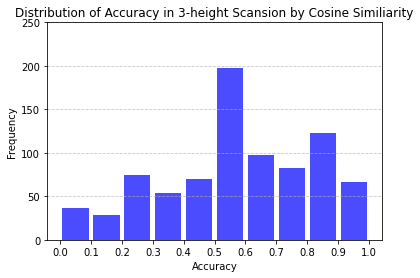

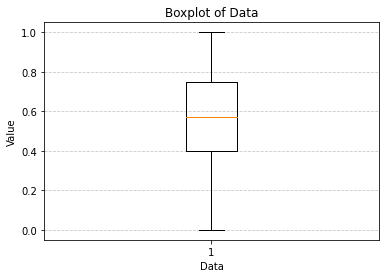

In [288]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace this with your own list of numbers)
data = mean_performance

# Define the range and interval for the x-axis
x_min = min(data)
x_max = max(data)
x_interval = 0.1
bins = np.arange(x_min, x_max + x_interval, x_interval)

# Create a histogram
plt.hist(data, bins=bins, color='blue', alpha=0.7, rwidth=0.85)
plt.xticks(np.arange(x_min, x_max + x_interval, x_interval))
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.ylim(0,250)
plt.title("Distribution of Accuracy in 3-height Scansion by Cosine Similiarity")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Create a boxplot
plt.boxplot(data)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Boxplot of Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()